In [1]:
import networkx as nx
import pandas as pd
import os
from itertools import combinations
import math
import matplotlib.pyplot as plt
import time
import numpy as np
import io
import imageio.v2 as imageio


In [2]:
leadership_path = r'C:\Projects\connecteddatahub\data\cleaned_dataframes\master_leadershipdata_validated.csv'
leadership_df = pd.read_csv(leadership_path)
board_df =  leadership_df[leadership_df['FixedPosition'] == 'Board Member']
print(board_df.shape)

(54697, 24)


In [3]:
data_path = r'C:\Projects\connecteddatahub\data'
yearly_edges_df = pd.read_csv(os.path.join(data_path, 'interlocks', 'yearly_interlocks.csv'))
nodes_df = pd.read_csv(os.path.join(data_path, 'interlocks', 'interlock_nodes.csv'))

=== Yearly Interlock Totals ===
 Year  TotalInterlocks
 1999              155
 2000              220
 2002              149
 2005              150
 2007              151
 2008              164
 2009              156
 2010              124
 2011              116
 2013              122
 2018              117

Global Graph Stats:
Nodes: 184
Edges: 481
Density: 0.0286



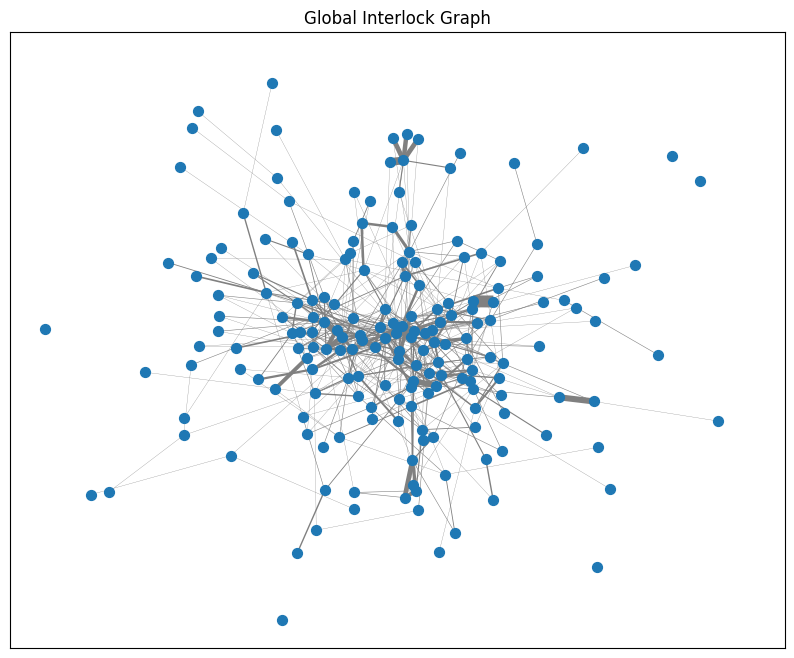

=== Year 1999 ===
Nodes: 204
Edges: 113
Density: 0.0055



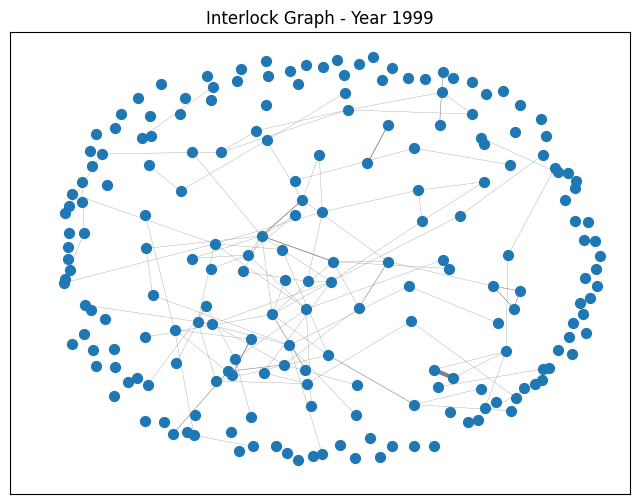

=== Year 2000 ===
Nodes: 212
Edges: 136
Density: 0.0061



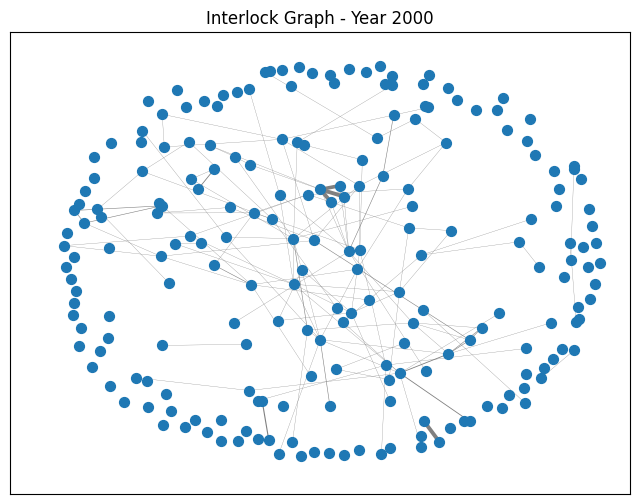

=== Year 2002 ===
Nodes: 216
Edges: 108
Density: 0.0047



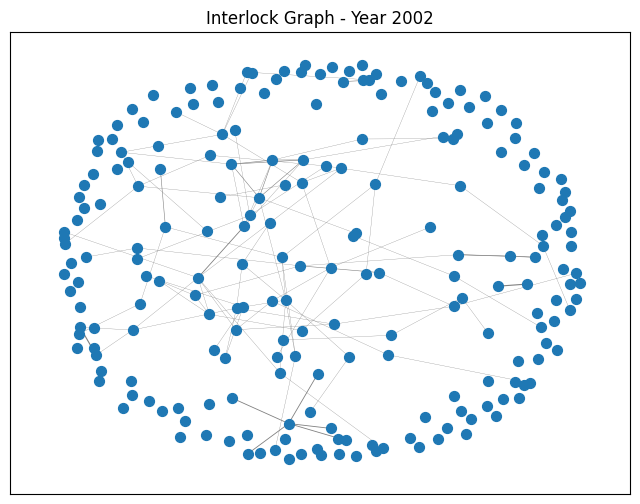

=== Year 2005 ===
Nodes: 207
Edges: 121
Density: 0.0057



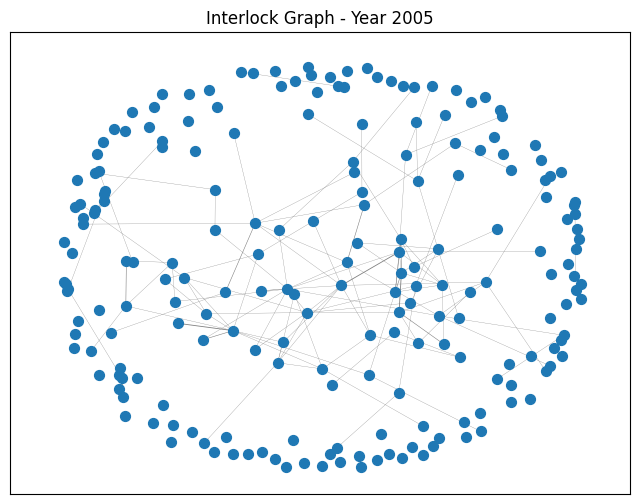

=== Year 2007 ===
Nodes: 208
Edges: 122
Density: 0.0057



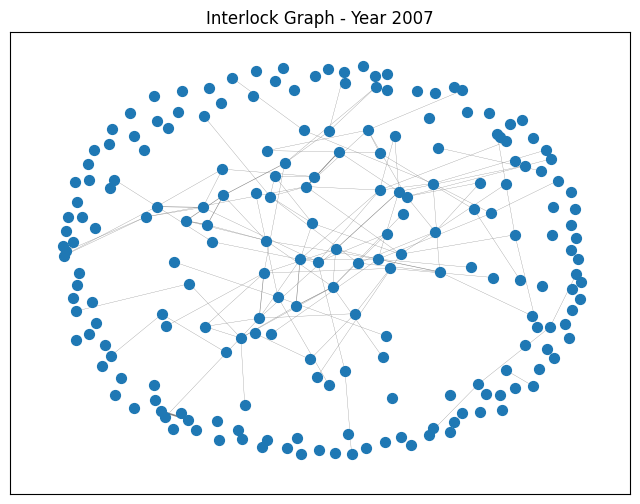

=== Year 2008 ===
Nodes: 217
Edges: 136
Density: 0.0058



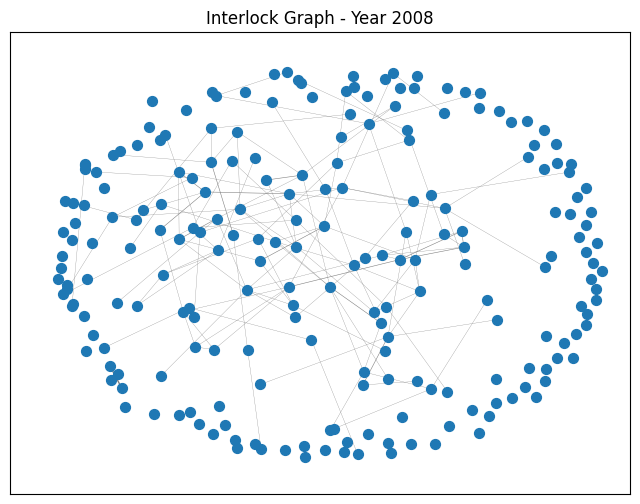

=== Year 2009 ===
Nodes: 203
Edges: 124
Density: 0.0060



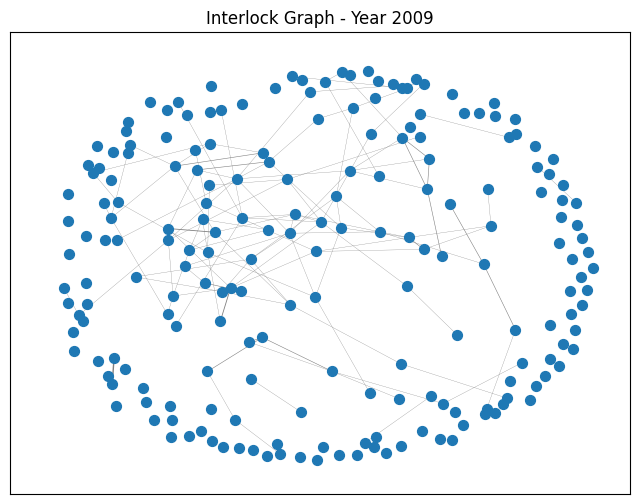

=== Year 2010 ===
Nodes: 185
Edges: 108
Density: 0.0063



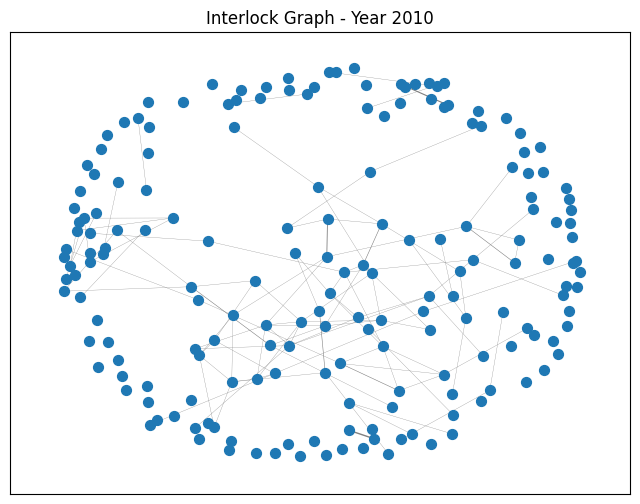

=== Year 2011 ===
Nodes: 177
Edges: 102
Density: 0.0065



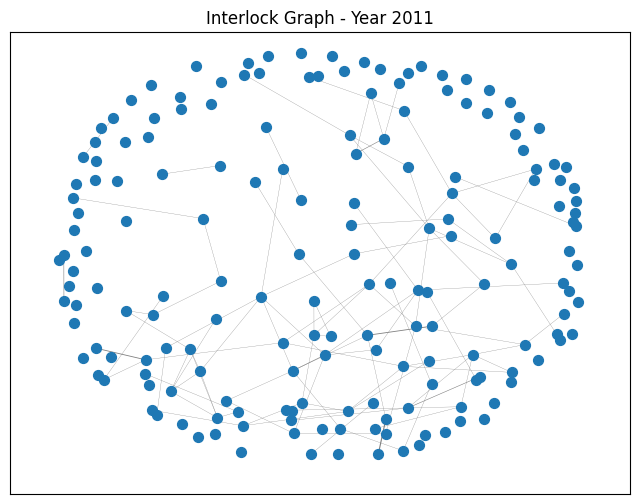

=== Year 2013 ===
Nodes: 170
Edges: 109
Density: 0.0076



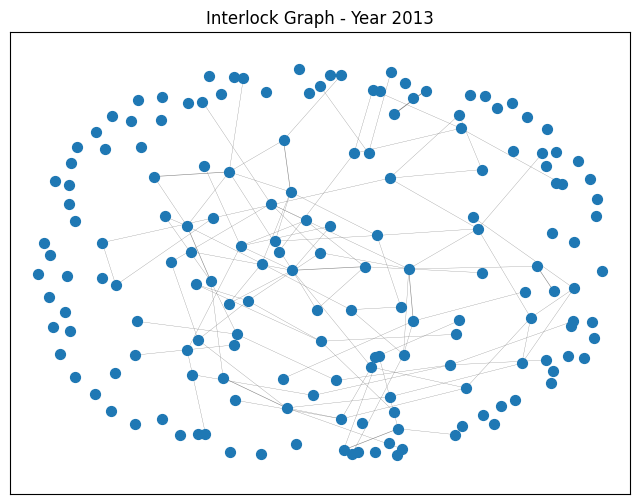

=== Year 2018 ===
Nodes: 173
Edges: 92
Density: 0.0062



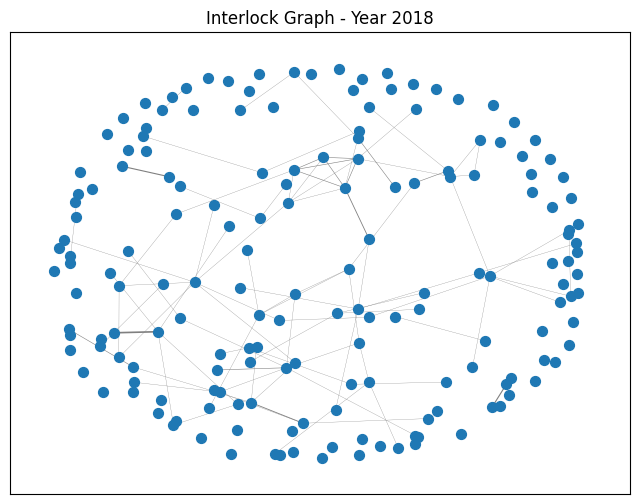

In [4]:
# Yearly totals (unchanged)
yearly_counts = (
    yearly_edges_df.groupby("Year")["InterlockCount"].sum().reset_index()
    .rename(columns={"InterlockCount": "TotalInterlocks"})
)

print("=== Yearly Interlock Totals ===")
print(yearly_counts.to_string(index=False))
print()

# Global interlocks network
G_global = nx.Graph()

# add all institutions as nodes (so isolated schools appear even with no interlocks)
G_global.add_nodes_from(
    nodes_df["Id"].dropna().astype(str).unique().tolist()
)

# only add valid edges (both endpoints present; weight > 0)
edge_rows = yearly_edges_df.dropna(subset=["AffiliationId_1", "AffiliationId_2"]).copy()
for _, row in edge_rows.iterrows():
    u = str(row["AffiliationId_1"])
    v = str(row["AffiliationId_2"])
    w = int(row["InterlockCount"]) if pd.notna(row["InterlockCount"]) else 0
    if w <= 0 or u == v:
        continue
    if G_global.has_edge(u, v):
        G_global[u][v]["weight"] += w
    else:
        G_global.add_edge(u, v, weight=w)

print("Global Graph Stats:")
print(f"Nodes: {G_global.number_of_nodes()}")
print(f"Edges: {G_global.number_of_edges()}")
print(f"Density: {nx.density(G_global):.4f}")
print()

# Plot Global Graph
plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_global, k=0.3, seed=42)
nx.draw_networkx(
    G_global, pos,
    with_labels=False, node_size=50, edge_color="gray",
    width=[0.2*G_global[u][v]["weight"] for u, v in G_global.edges()]
)
plt.title("Global Interlock Graph")
plt.show()

# Yearly Interlock Networks
G_yearly = {}
for year, edges in yearly_edges_df.groupby("Year"):
    G = nx.Graph()

    # include all schools that appear in that YEAR (even if they have no interlocks)
    year_nodes = (
        board_df.loc[board_df["Year"] == year, "AffiliationId"]
        .dropna().astype(str).unique().tolist()
    )
    G.add_nodes_from(year_nodes)

    # add edges for that year (valid endpoints only; weight > 0)
    valid_edges = edges.dropna(subset=["AffiliationId_1", "AffiliationId_2"]).copy()
    for _, row in valid_edges.iterrows():
        u = str(row["AffiliationId_1"])
        v = str(row["AffiliationId_2"])
        w = int(row["InterlockCount"]) if pd.notna(row["InterlockCount"]) else 0
        if w <= 0 or u == v:
            continue
        G.add_edge(u, v, weight=w)

    G_yearly[year] = G

    # Print stats
    print(f"=== Year {year} ===")
    print(f"Nodes: {G.number_of_nodes()}")
    print(f"Edges: {G.number_of_edges()}")
    print(f"Density: {nx.density(G):.4f}")
    print()

    # Plot
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(G, k=0.4, seed=42)
    nx.draw_networkx(
        G, pos,
        with_labels=False, node_size=50, edge_color="gray",
        width=[0.2*G[u][v]["weight"] for u, v in G.edges()]
    )
    plt.title(f"Interlock Graph - Year {year}")
    plt.show()


In [5]:
gif_name = "interlock_pruning_all_years.gif"
fps = 2
max_frames = 300

# Combine all yearly graphs into one weighted aggregate
G_full = nx.Graph()
for year, G in G_yearly.items():
    for u, v, d in G.edges(data=True):
        w = d.get("weight", 1)
        if G_full.has_edge(u, v):
            G_full[u][v]["weight"] += w
        else:
            G_full.add_edge(u, v, weight=w)

H = nx.Graph()
H.add_nodes_from(G_full.nodes(data=True))
H.add_edges_from(G_full.edges(data=True))

edges_sorted = sorted(
    G_full.edges(data=True),
    key=lambda e: (e[2].get("weight", 1), str(e[0]), str(e[1]))
)
m = len(edges_sorted)

pause_frames_start = int(fps * 1.0)
pause_frames_end = int(fps * 1.0)
budget_for_steps = max_frames - (pause_frames_start + pause_frames_end)
stride = max(1, math.ceil(m / max(1, budget_for_steps)))

pos = nx.spring_layout(H, k=0.4, seed=42)
frames = []

def draw_frame(G, step_label):
    fig = plt.figure(figsize=(8, 6), dpi=120)
    nx.draw_networkx_nodes(G, pos, node_size=40)
    if G.number_of_edges() > 0:
        widths = [0.4 * G[u][v].get("weight", 1) for u, v in G.edges()]
        nx.draw_networkx_edges(G, pos, width=widths, alpha=0.85)
    plt.title(f"All Years Combined | {step_label}")
    plt.axis("off")
    buf = io.BytesIO()
    fig.savefig(buf, format="png", dpi=120, bbox_inches="tight", pad_inches=0.05)
    plt.close(fig)
    buf.seek(0)
    arr = imageio.imread(buf)
    buf.close()
    return arr

frames.extend([draw_frame(H, f"removed: 0/{m}")] * pause_frames_start)

removed = 0
for i, (u, v, d) in enumerate(edges_sorted, start=1):
    if H.has_edge(u, v):
        H.remove_edge(u, v)
        removed += 1
    if (i % stride == 0) or (i == m):
        frames.append(draw_frame(H, f"removed: {removed}/{m} (w <= {d.get('weight', 1)})"))

frames.extend([frames[-1]] * pause_frames_end)

figures_path = r"C:\Projects\connecteddatahub\figures"
out_path = os.path.join(figures_path, gif_name)
imageio.mimsave(out_path, frames, duration=1.0 / fps, loop=0)

print(f"Saved GIF to: {out_path}")
print(f"Edges: {m}, stride: {stride}, total frames: {len(frames)}, duration ~ {len(frames)/fps:.1f}s")

Saved GIF to: C:\Projects\connecteddatahub\figures\interlock_pruning_all_years.gif
Edges: 481, stride: 2, total frames: 245, duration ~ 122.5s


In [6]:
def lcc_fraction(G):
    n = G.number_of_nodes()
    if n == 0:
        return 0.0
    if G.number_of_edges() == 0:
        return 1.0 / n
    return max(len(c) for c in nx.connected_components(G)) / n

In [7]:
''''
Edge pruning on network minus nodes with no edges.

Weakness of a tie here is calculated as the number of interlocks between two schools / board size 1 + board size 2
'''

def targeted_pruning_curve(G):
    # remove edges one-by-one in ascending normalized weight (weak-first)
    if G.number_of_edges() == 0:
        return np.array([0]), np.array([lcc_fraction(G)])

    # sort edges by weight asc; tie-break by endpoints for determinism
    edges_sorted = sorted(
        G.edges(data=True),
        key=lambda e: (e[2].get("weight", 0.0), str(e[0]), str(e[1]))
    )

    H = nx.Graph()
    H.add_nodes_from(G.nodes(data=True))
    H.add_edges_from(G.edges(data=True))

    x_removed = [0]
    y_lcc = [lcc_fraction(H)]
    removed = 0

    for u, v, d in edges_sorted:
        if H.has_edge(u, v):
            H.remove_edge(u, v)
            removed += 1
            x_removed.append(removed)
            y_lcc.append(lcc_fraction(H))

    return np.array(x_removed), np.array(y_lcc)


def random_pruning_curve(G, trials=50, seed=42):
    m = G.number_of_edges()
    k_removed = np.arange(m + 1)
    if m == 0:
        return k_removed, np.ones_like(k_removed, dtype=float), np.zeros_like(k_removed, dtype=float)

    rng = np.random.default_rng(seed)
    edges_list = list(G.edges())
    lcc_mat = np.zeros((trials, m + 1), dtype=float)

    for t in range(trials):
        order = rng.permutation(m)
        H = nx.Graph()
        H.add_nodes_from(G.nodes(data=True))
        H.add_edges_from(edges_list)
        lcc_mat[t, 0] = lcc_fraction(H)
        for i, idx in enumerate(order, start=1):
            u, v = edges_list[idx]
            if H.has_edge(u, v):
                H.remove_edge(u, v)
            lcc_mat[t, i] = lcc_fraction(H)

    return k_removed, lcc_mat.mean(axis=0), lcc_mat.std(axis=0)

def knee_index(x, y):
    if len(x) < 3:
        return len(x) - 1
    x0, y0 = x[0], y[0]
    x1, y1 = x[-1], y[-1]
    dx, dy = (x1 - x0), (y1 - y0)
    denom = np.hypot(dx, dy)
    if denom == 0:
        return len(x) - 1
    dist = np.abs(dy * (x - x0) - dx * (y - y0)) / denom
    return int(np.argmax(dist))

def summarize_year(G):
    # remove isolated nodes before analysis
    isolates = [n for n, deg in G.degree() if deg == 0]
    if isolates:
        G = G.copy()
        G.remove_nodes_from(isolates)

    n = G.number_of_nodes()
    m = G.number_of_edges()
    base = lcc_fraction(G)

    xt, yt = targeted_pruning_curve(G)
    kt = knee_index(xt, yt)
    kt_edges = int(xt[kt])
    kt_frac_removed = kt_edges / m if m else 0.0
    kt_lcc = float(yt[kt])

    kr, yr_mean, yr_std = random_pruning_curve(G, trials=50, seed=42)
    k50 = int(kr[np.argmax(yr_mean < 0.5)]) if np.any(yr_mean < 0.5) else None
    k50_frac = (k50 / m) if (k50 is not None and m) else None
    kr_knee = knee_index(kr, yr_mean)
    kr_knee_frac = (kr_knee / m) if m else 0.0

    curves = {
        "targeted_removed": xt,
        "targeted_lcc": yt,
        "random_removed": kr,
        "random_lcc_mean": yr_mean,
        "random_lcc_std": yr_std
    }

    summary = {
        "Nodes": n,
        "Edges": m,
        "BaselineLCC": base,
        "Targeted_Knee_EdgesRemoved": kt_edges,
        "Targeted_Knee_PctEdgesRemoved": kt_frac_removed,
        "Targeted_LCC_at_Knee": kt_lcc,
        "Random_k_at_50pct": k50,
        "Random_pct_edges_at_50pct": k50_frac,
        "Random_Knee_k": int(kr_knee),
        "Random_Knee_PctEdgesRemoved": kr_knee_frac
    }
    return summary, curves

def analyze_and_plot(G_yearly, years_to_plot=None, cols=3, figsize=(15, 10)):
    rows = []
    curves_by_year = {}

    for year in sorted(G_yearly.keys()):
        G = G_yearly[year]
        s, c = summarize_year(G)
        s_row = {"Year": year}
        s_row.update(s)
        rows.append(s_row)
        curves_by_year[year] = c

    summary_df = pd.DataFrame(rows).sort_values("Year").reset_index(drop=True)
    print(summary_df.to_string(index=False))

    plot_years = years_to_plot if years_to_plot is not None else summary_df["Year"].tolist()
    if len(plot_years) == 0:
        return summary_df

    nplots = len(plot_years)
    ncols = min(cols, nplots)
    nrows = int(np.ceil(nplots / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)

    for idx, year in enumerate(plot_years):
        r = idx // ncols
        c = idx % ncols
        ax = axes[r][c]

        curves = curves_by_year[year]
        G = G_yearly[year]
        m = max(G.number_of_edges(), 1)

        x_t = curves["targeted_removed"] / m
        y_t = curves["targeted_lcc"]
        x_r = curves["random_removed"] / m
        y_r = curves["random_lcc_mean"]
        y_r_std = curves["random_lcc_std"]

        ax.plot(x_t, y_t, label="targeted weak-first", linewidth=2)
        ax.plot(x_r, y_r, label="random mean", linewidth=2, linestyle="--")
        ax.fill_between(x_r, y_r - y_r_std, y_r + y_r_std, alpha=0.2, label="random std")

        ax.set_title(f"Year {year}")
        ax.set_xlabel("fraction of edges removed")
        ax.set_ylabel("largest component fraction")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

    for k in range(nplots, nrows * ncols):
        r = k // ncols
        c = k % ncols
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

    return summary_df


Summary for weakness = # Interlocks / sum(board_sizes)

 Year  Nodes  Edges  BaselineLCC  Targeted_Knee_EdgesRemoved  Targeted_Knee_PctEdgesRemoved  Targeted_LCC_at_Knee  Random_k_at_50pct  Random_pct_edges_at_50pct  Random_Knee_k  Random_Knee_PctEdgesRemoved
 1999    103    113     0.669903                          50                       0.442478              0.223301                 30                   0.265487             66                     0.584071
 2000    111    136     0.837838                          79                       0.580882              0.216216                 55                   0.404412             90                     0.661765
 2002     96    108     0.781250                          41                       0.379630              0.281250                 32                   0.296296             66                     0.611111
 2005     97    121     0.804124                          66                       0.545455              0.463918               

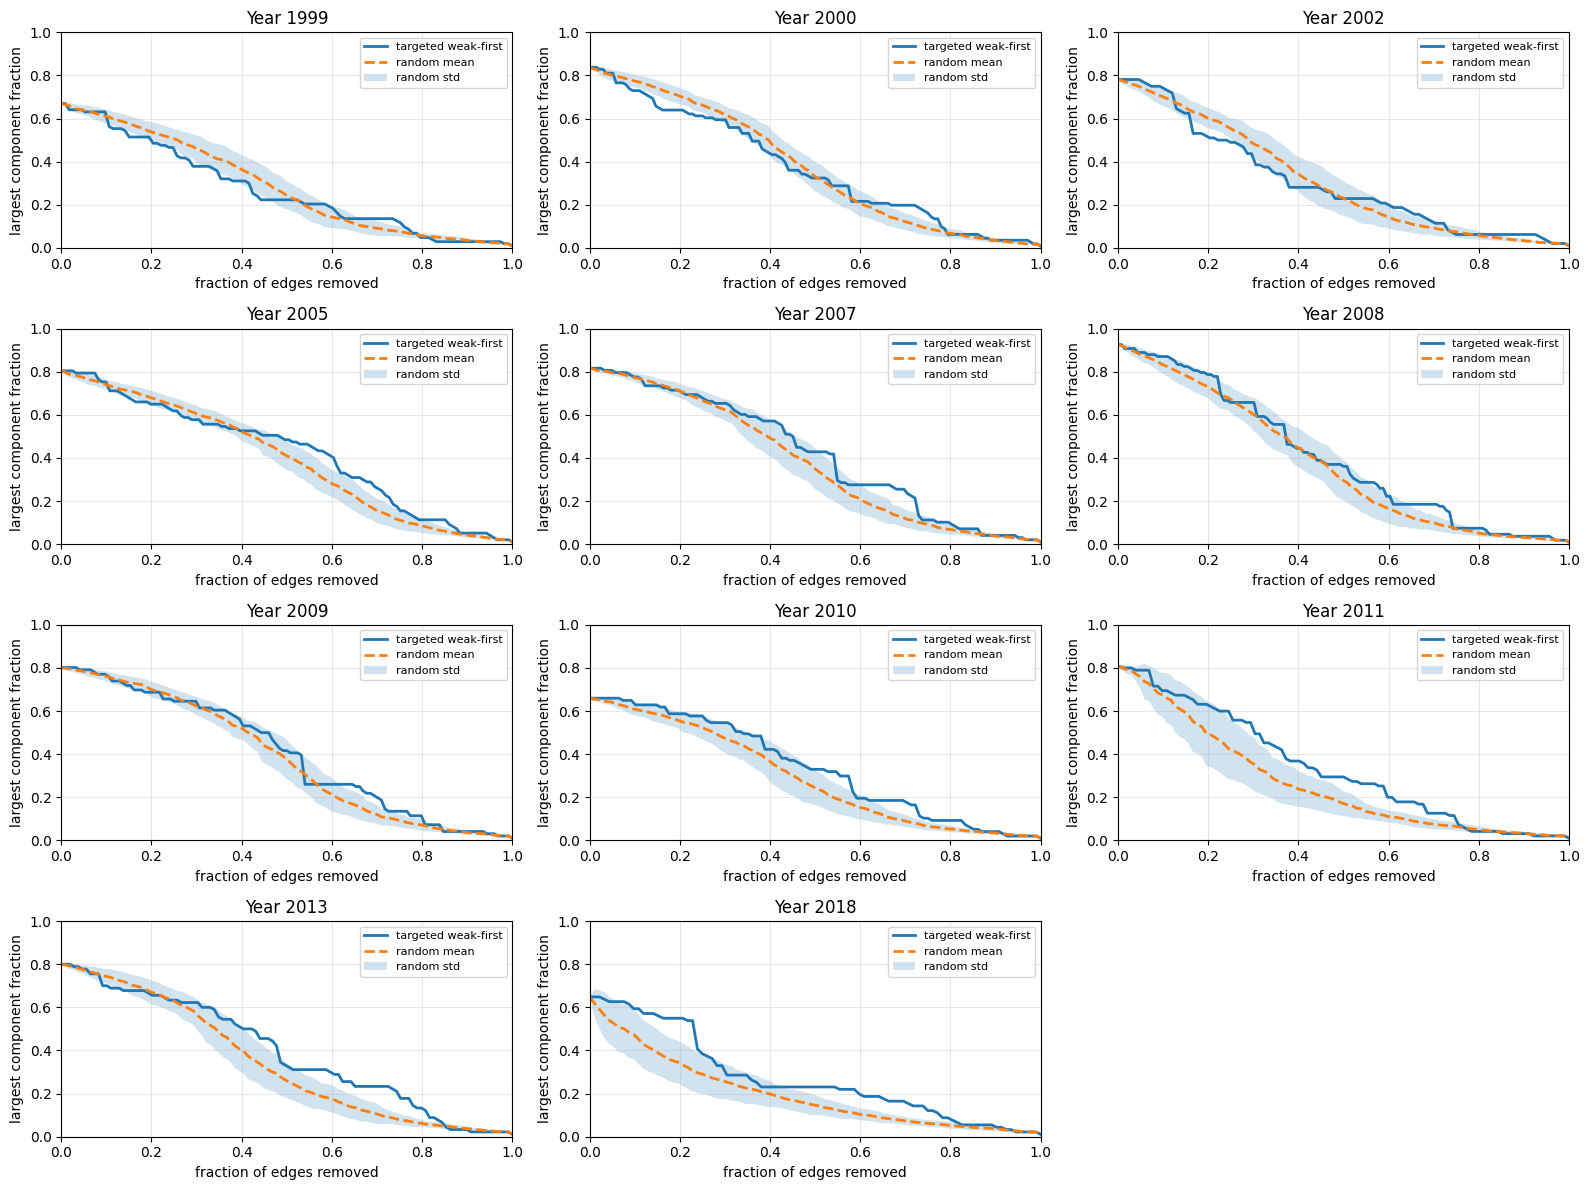

In [8]:
print("Summary for weakness = # Interlocks / sum(board_sizes)\n")
summary = analyze_and_plot(G_yearly, years_to_plot=None, cols=3, figsize=(16, 12))

In [9]:
"""
Edge pruning but weakness of edges is a combination of neighborhood overlap (number of shared neighbors / number of total neighbors) and the bewteenness centrality of nodes. 
I am using both because there tends to be a lot of interlocks with the same value for neighborhood overlap and I needed a way to differentiate them. Weight split is .7 - .3
"""


def compute_neighborhood_overlap(G):
    """
    Compute neighborhood overlap for every edge (u, v):
        overlap = |Γ(u) ∩ Γ(v)| / (|Γ(u) ∪ Γ(v)| - 2)
    where Γ(x) = set of neighbors of x (excluding x itself).
    """
    overlap = {}
    for u, v in G.edges():
        Nu = set(G.neighbors(u)) - {v}
        Nv = set(G.neighbors(v)) - {u}
        inter = len(Nu & Nv)
        denom = len(Nu | Nv)
        overlap_val = inter / (denom - 2) if denom > 2 else 0.0
        overlap[(u, v)] = overlap_val
    nx.set_edge_attributes(G, overlap, "overlap")
    return overlap


def compute_edge_betweenness(G):
    """
    Compute edge betweenness centrality (EBC) for all edges.
    Normalized in [0, 1]; measures how often an edge lies on shortest paths
    across the network, capturing its role as a bridge between communities.
    """
    ebc = nx.edge_betweenness_centrality(G, normalized=True)
    nx.set_edge_attributes(G, ebc, "betweenness")
    return ebc


def targeted_pruning_curve(G, alpha=0.7, beta=0.3):
    compute_neighborhood_overlap(G)
    compute_edge_betweenness(G)

    # print correlation between overlap and betweenness to inspect complementarity
    overlaps = nx.get_edge_attributes(G, 'overlap').values()
    bets = nx.get_edge_attributes(G, 'betweenness').values()
    print("Correlation between neighborhood overlap and betweenness centrality", np.corrcoef(list(overlaps), list(bets))[0, 1])

    if G.number_of_edges() == 0:
        return np.array([0]), np.array([lcc_fraction(G)])

    # calculate composite weakness score for each edge
    weakness_scores = {}
    for u, v, d in G.edges(data=True):
        overlap = d.get("overlap", 0.0)
        bet = d.get("betweenness", 0.0)
        weakness = alpha * (1 - overlap) + beta * bet
        weakness_scores[(u, v)] = weakness
    nx.set_edge_attributes(G, weakness_scores, "weakness")

    # sort edges by weakness (weakest first)
    edges_sorted = sorted(
        G.edges(data=True),
        key=lambda e: (e[2].get("weakness", 0.0), str(e[0]), str(e[1])),
        reverse=True
    )

    print(edges_sorted)

    # iteratively remove edges and record largest connected component (LCC) fraction
    H = nx.Graph()
    H.add_nodes_from(G.nodes(data=True))
    H.add_edges_from(G.edges(data=True))

    x_removed = [0]
    y_lcc = [lcc_fraction(H)]
    removed = 0

    for u, v, d in edges_sorted:
        if H.has_edge(u, v):
            H.remove_edge(u, v)
            removed += 1
            x_removed.append(removed)
            y_lcc.append(lcc_fraction(H))

    return np.array(x_removed), np.array(y_lcc)


def random_pruning_curve(G, trials=50, seed=123):
    """Simulate random edge removals as a baseline for comparison."""
    m = G.number_of_edges()
    k_removed = np.arange(m + 1)
    if m == 0:
        return k_removed, np.ones_like(k_removed, dtype=float), np.zeros_like(k_removed, dtype=float)

    rng = np.random.default_rng(seed)
    edges_list = list(G.edges())
    lcc_mat = np.zeros((trials, m + 1), dtype=float)

    for t in range(trials):
        order = rng.permutation(m)
        H = nx.Graph()
        H.add_nodes_from(G.nodes(data=True))
        H.add_edges_from(edges_list)
        lcc_mat[t, 0] = lcc_fraction(H)
        for i, idx in enumerate(order, start=1):
            u, v = edges_list[idx]
            if H.has_edge(u, v):
                H.remove_edge(u, v)
            lcc_mat[t, i] = lcc_fraction(H)

    return k_removed, lcc_mat.mean(axis=0), lcc_mat.std(axis=0)


def knee_index(x, y):
    """Find the index corresponding to the largest curvature ('knee point') of a curve."""
    if len(x) < 3:
        return len(x) - 1
    x0, y0 = x[0], y[0]
    x1, y1 = x[-1], y[-1]
    dx, dy = (x1 - x0), (y1 - y0)
    denom = np.hypot(dx, dy)
    if denom == 0:
        return len(x) - 1
    dist = np.abs(dy * (x - x0) - dx * (y - y0)) / denom
    return int(np.argmax(dist))


def summarize_year(G):
    """
    Compute summary statistics for a single yearly interlock network.
    Removes isolated nodes, performs targeted and random pruning,
    and returns both summary metrics and LCC decay curves.
    """
    isolates = [n for n, deg in G.degree() if deg == 0]
    if isolates:
        G = G.copy()
        G.remove_nodes_from(isolates)

    n = G.number_of_nodes()
    m = G.number_of_edges()
    base = lcc_fraction(G)

    # targeted removal based on overlap + betweenness
    xt, yt = targeted_pruning_curve(G)
    kt = knee_index(xt, yt)
    kt_edges = int(xt[kt])
    kt_frac_removed = kt_edges / m if m else 0.0
    kt_lcc = float(yt[kt])

    # random edge removal baseline
    kr, yr_mean, yr_std = random_pruning_curve(G, trials=50, seed=42)
    k50 = int(kr[np.argmax(yr_mean < 0.5)]) if np.any(yr_mean < 0.5) else None
    k50_frac = (k50 / m) if (k50 is not None and m) else None
    kr_knee = knee_index(kr, yr_mean)
    kr_knee_frac = (kr_knee / m) if m else 0.0

    curves = {
        "targeted_removed": xt,
        "targeted_lcc": yt,
        "random_removed": kr,
        "random_lcc_mean": yr_mean,
        "random_lcc_std": yr_std
    }

    summary = {
        "Nodes": n,
        "Edges": m,
        "BaselineLCC": base,
        "Targeted_Knee_EdgesRemoved": kt_edges,
        "Targeted_Knee_PctEdgesRemoved": kt_frac_removed,
        "Targeted_LCC_at_Knee": kt_lcc,
        "Random_k_at_50pct": k50,
        "Random_pct_edges_at_50pct": k50_frac,
        "Random_Knee_k": int(kr_knee),
        "Random_Knee_PctEdgesRemoved": kr_knee_frac
    }
    return summary, curves


def analyze_and_plot(G_yearly, years_to_plot=None, cols=3, figsize=(15, 10)):
    """
    Run the yearly analysis across all provided networks, summarize,
    and plot the targeted vs random pruning curves for each year.
    """
    rows = []
    curves_by_year = {}

    for year in sorted(G_yearly.keys()):
        G = G_yearly[year]
        s, c = summarize_year(G)
        s_row = {"Year": year}
        s_row.update(s)
        rows.append(s_row)
        curves_by_year[year] = c

    summary_df = pd.DataFrame(rows).sort_values("Year").reset_index(drop=True)
    print(summary_df.to_string(index=False))

    plot_years = years_to_plot if years_to_plot is not None else summary_df["Year"].tolist()
    if len(plot_years) == 0:
        return summary_df

    nplots = len(plot_years)
    ncols = min(cols, nplots)
    nrows = int(np.ceil(nplots / ncols))
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize, squeeze=False)

    for idx, year in enumerate(plot_years):
        r = idx // ncols
        c = idx % ncols
        ax = axes[r][c]

        curves = curves_by_year[year]
        G = G_yearly[year]
        m = max(G.number_of_edges(), 1)

        x_t = curves["targeted_removed"] / m
        y_t = curves["targeted_lcc"]
        x_r = curves["random_removed"] / m
        y_r = curves["random_lcc_mean"]
        y_r_std = curves["random_lcc_std"]

        ax.plot(x_t, y_t, label="targeted (low-overlap + high-betweenness)", linewidth=2)
        ax.plot(x_r, y_r, label="random mean", linewidth=2, linestyle="--")
        ax.fill_between(x_r, y_r - y_r_std, y_r + y_r_std, alpha=0.2, label="random std")

        ax.set_title(f"Year {year}")
        ax.set_xlabel("Fraction of edges removed")
        ax.set_ylabel("Largest component fraction")
        ax.set_xlim(0, 1)
        ax.set_ylim(0, 1)
        ax.grid(True, alpha=0.3)
        ax.legend(fontsize=8)

    # turn off unused subplots
    for k in range(nplots, nrows * ncols):
        r = k // ncols
        c = k % ncols
        axes[r][c].axis("off")

    plt.tight_layout()
    plt.show()

    return summary_df


Correlation between neighborhood overlap and betweenness centrality -0.2697639952104708
[('5388228', '87208437', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.06402690526048609, 'weakness': 0.7192080715781458}), ('145311948', '5388228', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.06091757091185989, 'weakness': 0.718275271273558}), ('74973139', '165102784', {'weight': 3, 'overlap': 0.0, 'betweenness': 0.05629798845104385, 'weakness': 0.7168893965353131}), ('57206974', '107639228', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.051510248112189856, 'weakness': 0.7154530744336569}), ('40347166', '5388228', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.05032045180531759, 'weakness': 0.7150961355415952}), ('118353179', '165102784', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.04949552636588616, 'weakness': 0.7148486579097658}), ('184565670', '17626003', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.04840091376356367, 'weakness': 0.714520274129069}), ('111088046', '74973139', {'weight

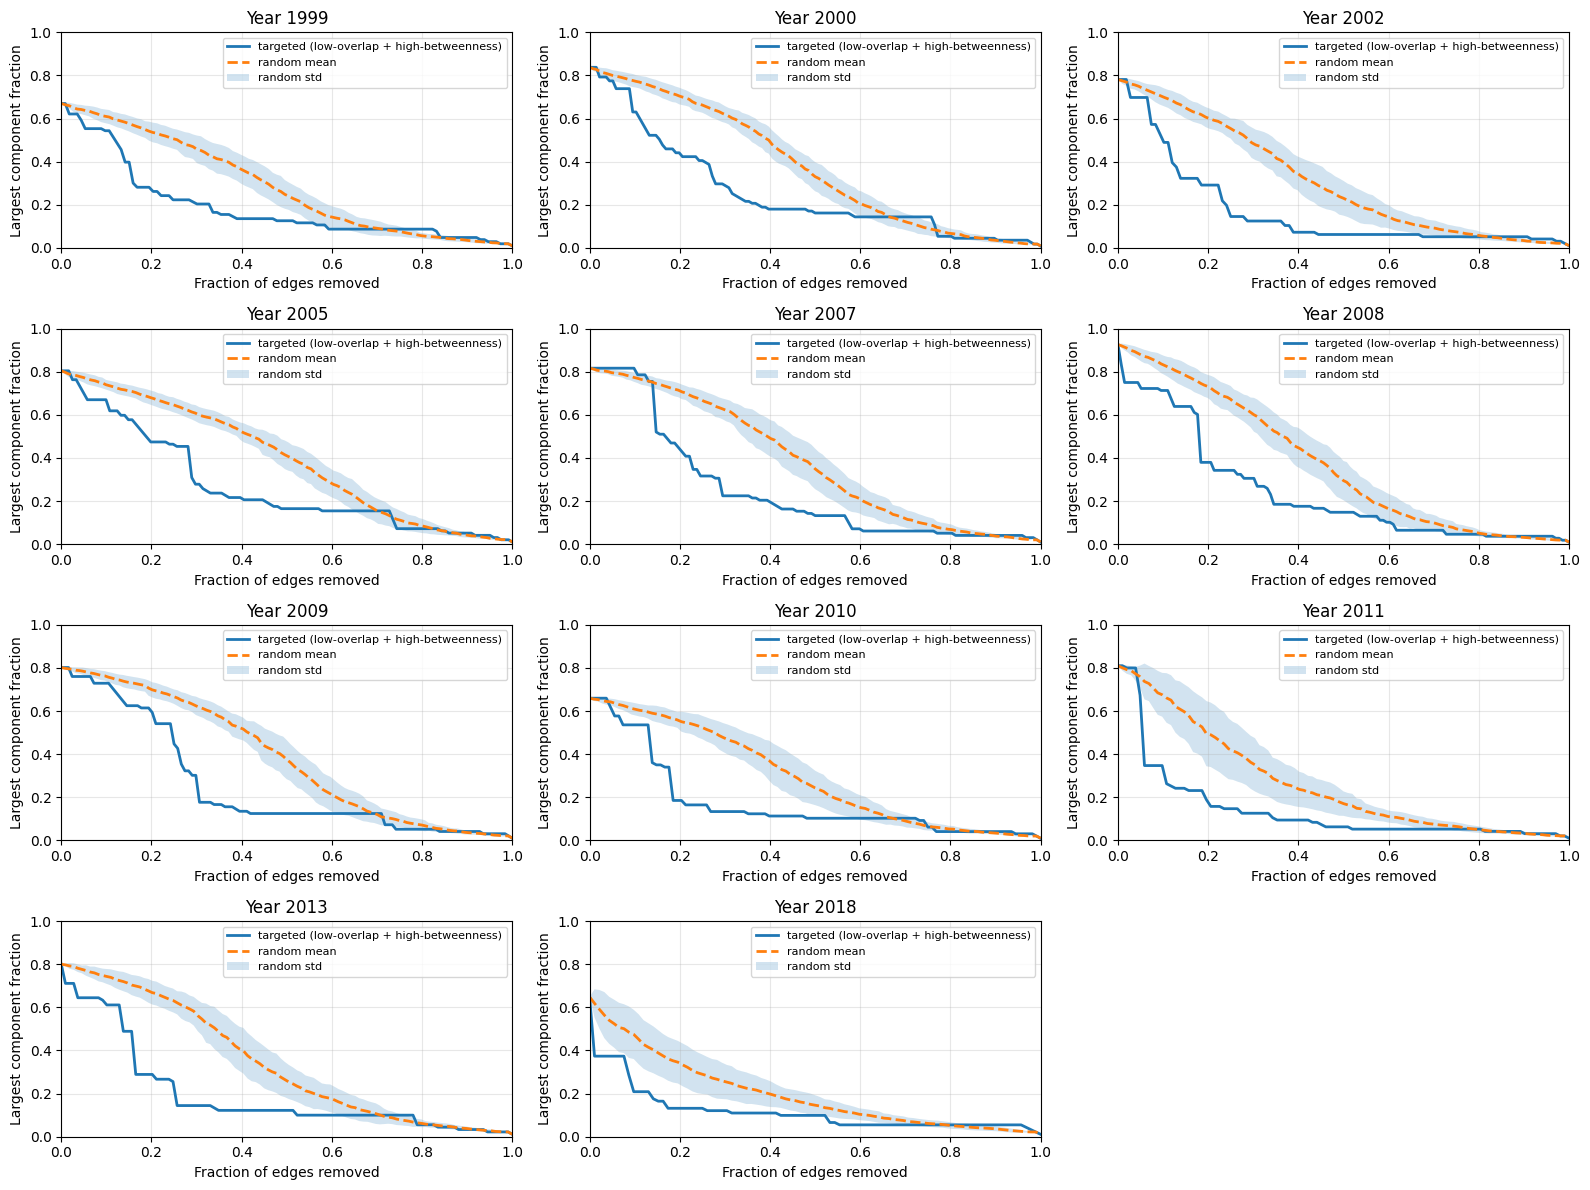

In [10]:
summary = analyze_and_plot(G_yearly, years_to_plot=None, cols=3, figsize=(16, 12))

In [11]:
def _auc_from_curve(x_frac, y):
    """
    Compute area under the LCC curve using the trapezoid rule.
    x_frac must be in [0,1], y in [0,1].
    """
    return float(np.trapz(y, x_frac))

def auc_difference_per_year(G_yearly):
    """
    For each year:
      1) run targeted_pruning_curve(G)  -> (xt, yt)
      2) run random_pruning_curve(G)    -> (kr, yr_mean, yr_std)
      3) normalize x to fraction of edges removed
      4) compute AUCs and their difference
    Returns a DataFrame sorted by year.
    """
    rows = []
    for year in sorted(G_yearly.keys()):
        G = G_yearly[year]
        m = max(G.number_of_edges(), 1)

        # targeted curve
        xt, yt = targeted_pruning_curve(G)              # arrays of length m+1
        x_t = xt / m

        # random baseline (mean and std)
        kr, yr_mean, yr_std = random_pruning_curve(G)   # kr is 0..m
        x_r = kr / m

        # AUCs
        auc_targeted = _auc_from_curve(x_t, yt)
        auc_random   = _auc_from_curve(x_r, yr_mean)

        # optional: integrate mean±std to get a band for random AUC
        auc_random_lo = _auc_from_curve(x_r, np.maximum(yr_mean - yr_std, 0.0))
        auc_random_hi = _auc_from_curve(x_r, np.minimum(yr_mean + yr_std, 1.0))

        rows.append({
            "Year": year,
            "Edges": int(G.number_of_edges()),
            "AUC_Targeted": auc_targeted,
            "AUC_RandomMean": auc_random,
            "AUC_RandomMean_Lo": auc_random_lo,
            "AUC_RandomMean_Hi": auc_random_hi,
            "AUC_Diff": auc_random - auc_targeted
        })

    df = pd.DataFrame(rows).sort_values("Year").reset_index(drop=True)
    return df


auc_df = auc_difference_per_year(G_yearly)
print(auc_df.to_string(index=False))

Correlation between neighborhood overlap and betweenness centrality -0.2697639952104706
[('5388228', '87208437', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.01624327892076371, 'weakness': 0.7048729836762291}), ('145311948', '5388228', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.015454457645127017, 'weakness': 0.704636337293538}), ('74973139', '165102784', {'weight': 3, 'overlap': 0.0, 'betweenness': 0.01428249460703822, 'weakness': 0.7042847483821114}), ('57206974', '107639228', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.013067870826491516, 'weakness': 0.7039203612479474}), ('40347166', '5388228', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.012766025950610129, 'weakness': 0.703829807785183}), ('118353179', '165102784', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.0125567468366657, 'weakness': 0.7037670240509997}), ('184565670', '17626003', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.012279049550854822, 'weakness': 0.7036837148652564}), ('111088046', '74973139', {'weig

C:\Users\tykun\AppData\Local\Temp\ipykernel_22572\782485478.py:6: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(y, x_frac))


Correlation between neighborhood overlap and betweenness centrality -0.16772165089478044
[('83399316', '161515732', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.031383768446721146, 'weakness': 0.7094151305340163}), ('184565670', '17626003', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.023226900525031617, 'weakness': 0.7069680701575094}), ('111088046', '74973139', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.019672717517660733, 'weakness': 0.7059018152552982}), ('103531236', '57206974', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.018979896498227903, 'weakness': 0.7056939689494683}), ('102461120', '47838141', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.01835116084646623, 'weakness': 0.7055053482539398}), ('150468666', '17626003', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.018189492554600305, 'weakness': 0.7054568477663801}), ('102461120', '161515732', {'weight': 1, 'overlap': 0.0, 'betweenness': 0.017626918125442672, 'weakness': 0.7052880754376327}), ('193531525', '102461